# TP 2 : Conditions de bord #

In [1]:
# Import des librairies nécessaires

import numpy as np
from numpy.polynomial import polynomial as P

#%matplotlib widget
import matplotlib.pyplot as plt
from math import *


Commençons par réécrire le schéma $D_1Q_2$ vu dans le TP1, en ajoutant une phase de traitement des conditions aux bords juste avant la phase de transport.
Les différents types de conditions aux bords apparaissent dans la fonction *boundary_conditions*.

In [48]:
def boundary_conditions(f0,f1,bcs,lamb,c):

    #periodical boundary conditions
    if bcs=="periodic":
        f0[-1] = f0[1]
        f1[0] = f1[-2]

    # No boundary conditions
    if bcs=="None":
        f0[0:-1] = f0[1:]
        f1[1:] = f1[:-1]

    # Bounce back conditions
    if bcs=="bounce_back":
        f0[-1] = f1[-2]
        f1[0] = f0[1]

    # Anti Bounce back conditions
    if bcs=="anti_bounce_back":
        f0[-1] = -f1[-2]
        f1[0] = -f0[1]
        
    # Copy boundary conditions
    if bcs=="copy":
        f0[-1] = f0[-2]
        f1[0] = f1[1]

    # Out boundary conditions
    if bcs=="helluy":
        f0[-1] = (lamb-c)/(lamb+c)*f1[-2]
        f1[0] = -f0[1] # condition de Dirichlet sur m0 (comme anti bounce back)

    # Out boundary conditions for Burgers
    if bcs == "helluy_burgers":
        f0[-1] = -f1[-2] - lamb + sqrt(lamb*(lamb+4*f1[-2]))
        f1[0] = -f0[1]
        #f1[0] = -f0[1] + lamb + sqrt(lamb*(lamb-4*f0[1]))
        

def transport(f0,f1):
    f0[1:-1] = f0[2:]
    f1[1:-1] = f1[:-2]

    

In [3]:
# Fonction pour générer le réseau

def mesh(N,xmin=0.,xmax=1.):
    dx = 1./N
    x = np.linspace(xmin-dx/2,xmax+dx/2,N+2)
    return x

# Implémentation du schéma

def f2m(m0,m1,f0,f1,lamb):
    m0[:] = f0 + f1
    m1[:] = -1*lamb*f0 + lamb*f1

def m2f(m0,m1,f0,f1,lamb):
    f0[:] = 0.5*(m0-m1/lamb)
    f1[:] = 0.5*(m0+m1/lamb)

def initialize_mesh(x, lamb, m0_init, eq_fun, param_init, xmin=0.,xmax=1.):
    m0 = m0_init(x, xmin, xmax, param_init)
    m1 = eq_fun(m0)
    f0, f1 = np.empty(m0.shape), np.empty(m0.shape)
    m2f(m0,m1,f0,f1,lamb)
    return f0,f1,m0,m1

def relaxation(m0,m1,s1,eq_fun):
    m1[:] = m1 + s1*(eq_fun(m0)-m1)



# Fonction principale pour faire tourner le schéma

def run_lbm(x, dt, Tf,lamb, s1, m0_init, eq_fun, param_init, xmin=0., xmax=1., bcs="None",nplots=0,axplot=None,full=False):
    f0,f1,m0,m1 = initialize_mesh(x,lamb,m0_init,eq_fun,param_init,xmin,xmax)
    t = 0
    if full: # contiendra les m0 à chaque instant calculé
        full_m0 = [m0.tolist()]
    if nplots !=0:
        Nt = int(floor(Tf/dt))
        iplot = int(Nt/nplots)
        i=0
    while t < Tf:
        t += dt
        relaxation(m0,m1,s1,eq_fun)
        m2f(m0,m1,f0,f1,lamb)
        boundary_conditions(f0,f1,bcs,lamb,0.25)
        transport(f0,f1)
        f2m(m0,m1,f0,f1,lamb)
        
        if full:
            full_m0.append(m0.tolist())

        if nplots!=0:
            i+=1
            if i%iplot==0:
                plot_lbm(x,m0,"t",round(t,2),axplot)
    if full:
        return m0, t, np.array(full_m0)
    else:
        return m0

# Fonction d'affichage des résultats

def plot_lbm(x,m0,text,value,ax=None):
    if ax==None:
        plt.plot(x[1:-1], m0[1:-1], label=text+"="+str(value),)    
        plt.xlabel("x")
        plt.ylabel("m0")
        plt.legend()
    else:
        ax.plot(x[1:-1], m0[1:-1], label=text+"="+str(value),)
        ax.set_xlabel("x")
        ax.set_ylabel("m0")
        ax.legend()

# Condition initiale (fonction bump)

def m0_init_bump(x, xmin, xmax, reg):
    """
    initial condition
    """
    middle, width = 0.75 * xmin + 0.25 * xmax, 0.125 * (xmax - xmin)
    x_left, x_right = middle - width, middle + width
    output = np.zeros(x.shape)

    ind_l = np.where(np.logical_and(x > x_left, x <= middle))
    ind_r = np.where(np.logical_and(x < x_right, x > middle))
    x_sl = (x[ind_l] - x_left - 0.5 * width) / (0.5 * width)
    x_sl_k = np.copy(x_sl)
    x_sl *= x_sl
    x_sr = (x[ind_r] - middle - 0.5 * width) / (0.5 * width)
    x_sr_k = np.copy(x_sr)
    x_sr *= x_sr
    
    def binomial(n, k):
        if 0 <= k <= n:
            ntok = 1
            ktok = 1
            for t in range(1, min(k, n - k) + 1):
                ntok *= n
                ktok *= t
                n -= 1
            return ntok // ktok
        else:
            return 0

    cte = 0.0
    for k in range(reg + 1):
        coeff = (-1) ** k * binomial(reg, k) / (2 * k + 1)
        output[ind_l] += coeff * x_sl_k
        output[ind_r] -= coeff * x_sr_k
        cte += coeff
        x_sl_k *= x_sl
        x_sr_k *= x_sr
    output[ind_l] += cte
    output[ind_r] += cte
    output /= 2 * cte
    return output

### Exercice 1 : Equation d'advection

Nous allons étudier différents types de conditions aux bord pour l'équation d'advection. Pour chaque type, nous testerons les conditions pour différentes valeurs du paramètre de relaxation $s$, incluant $s = 2$, ainsi que pour différentes valeur de la vitesse du réseau $λ = \frac{dx}{dt}$ ($c$ étant fixé à $0.25$). Nous tracerons ensuite les solutions à différents instants. Les instants d'affichages sont choisis avec un léger décalage par rapport à la période, afin d'éviter une superposition des courbes. Puis, les deux dernières figures présenterons les différentes solutions selon $s$ (à gauche) ou $\lambda$ (à droite) au bout d'une "période" de temps (ou deux pour certains types de conditions initiales). Notons qu'ici, la "période" de temps vaut $T = \frac{x_{Nx} - x_0}{c} = 4$. Bien sûr, on ne peut réellement parler de période que pour les conditions périodiques ; cependant, nous verrons que pour d'autres types de conditions, cette durée aura aussi un rôle particulier.

#### Question 1 - Conditions périodiques

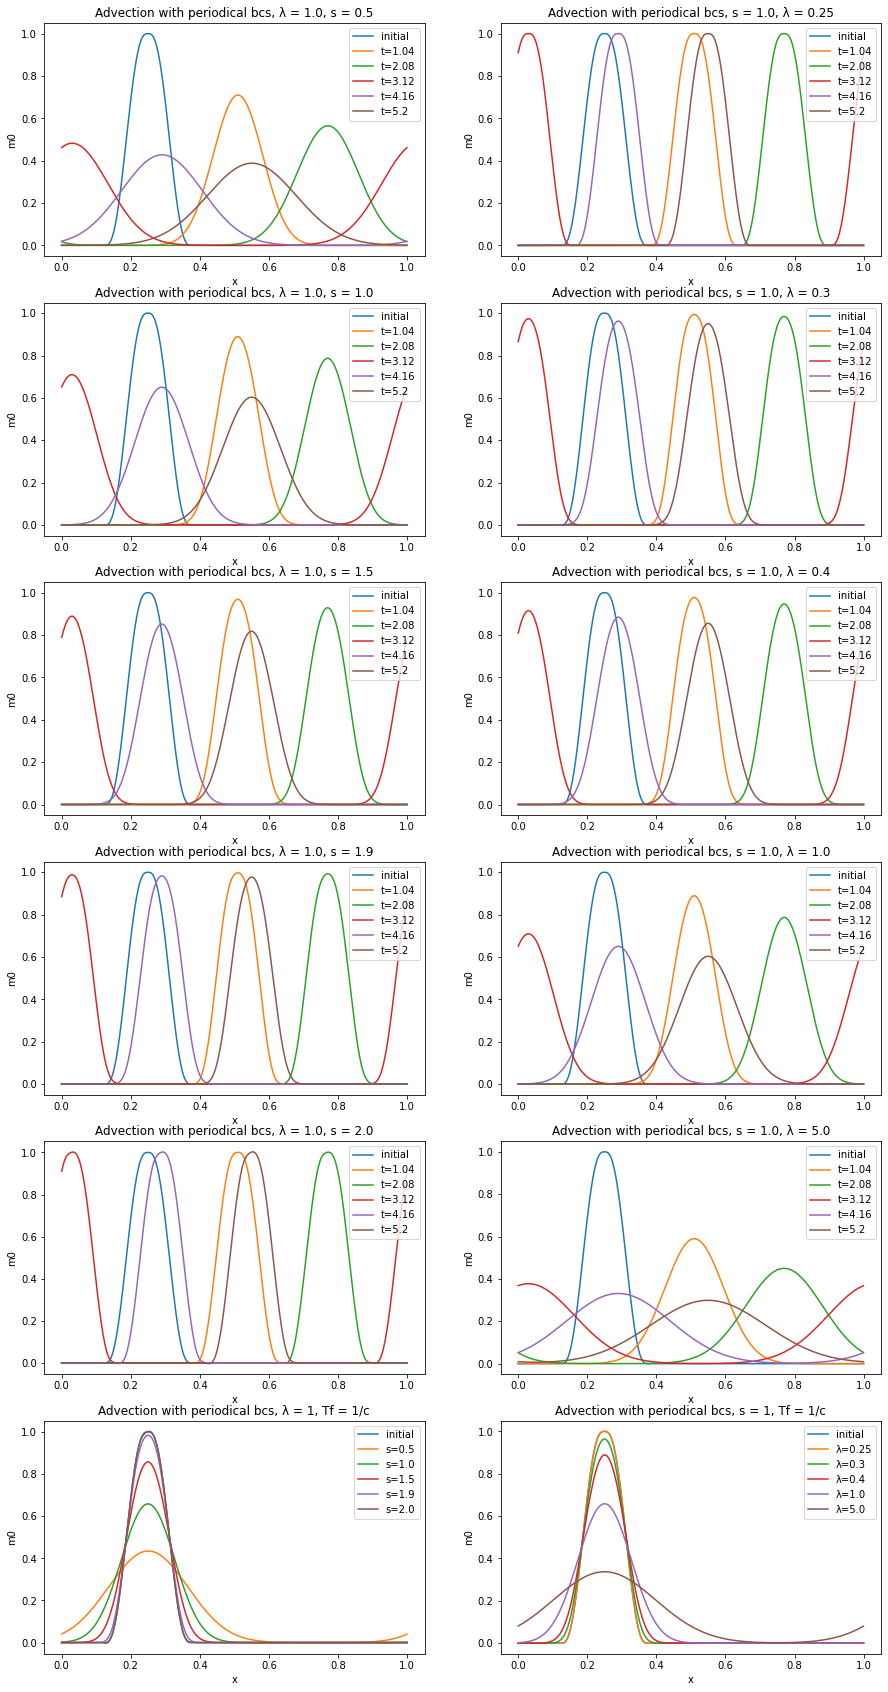

In [4]:
# Conditions périodiques 

nx = 1000

x = mesh(nx)
dx = 1./nx
c = 0.25
lamb = 1.
dt = dx/lamb
svec = [0.5,1.,1.5,1.9,2.]
nb_s = len(svec)

eq_advection = lambda m0: c*m0

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 5.2

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="periodic",nplots=5,axplot=ax1)
    ax1.set_title("Advection with periodical bcs, λ = "+str(lamb)+", s = "+str(s));

# On vérifie que la solution est bien superposée après une période
Tf = 4.0
ax2 = axs[nb_s,0]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="periodic")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Advection with periodical bcs, λ = 1, Tf = 1/c");


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.
lambvec = [0.25, 0.3, 0.4,1., 5. ]

# On commence par afficher la solution pour différents temps
Tf = 5.2

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="periodic",nplots=5,axplot=ax1)
    ax1.set_title("Advection with periodical bcs, s = "+str(s)+", λ = "+ str(lamb));

# On vérifie que la solution est bien superposée après une période
Tf = 4.0
ax2 = axs[nb_s,1]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="periodic")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Advection with periodical bcs, s = 1, Tf = 1/c");

On observe bien que lorsque que la solution atteint le bord droit, elle réapparaît à gauche et se comporte comme précédement. Elle est donc périodique, modulo la diffusion numérique observée pour certaines valeurs de $s$ et $\lambda$. Pour $λ = 1$ et $s<2$ , on observe une diffusion numérique qui s'accentue quand $s$ diminue, tandis que pour $s=1$ et $λ > c$, on observe une diffusion numérique qui s'accentue quand $\lambda$ augmente.

En revanche, pour $s = 2$ ou $λ = c$ (et $s ≠ 2$), la solution est périodique : on observe une superposition presque parfaite entre la condition initiale et la solution à l'instant $T$.

Ce type de conditions aux bords fonctionne donc bien avec le schéma $D_1Q_2$. Toutefois, elles ne correspondent pas toujours à la réalité physique. Nous allons donc étudier dans la suite d'autres types de conditions aux bords.

#### Question 2 : Bounce Back condition

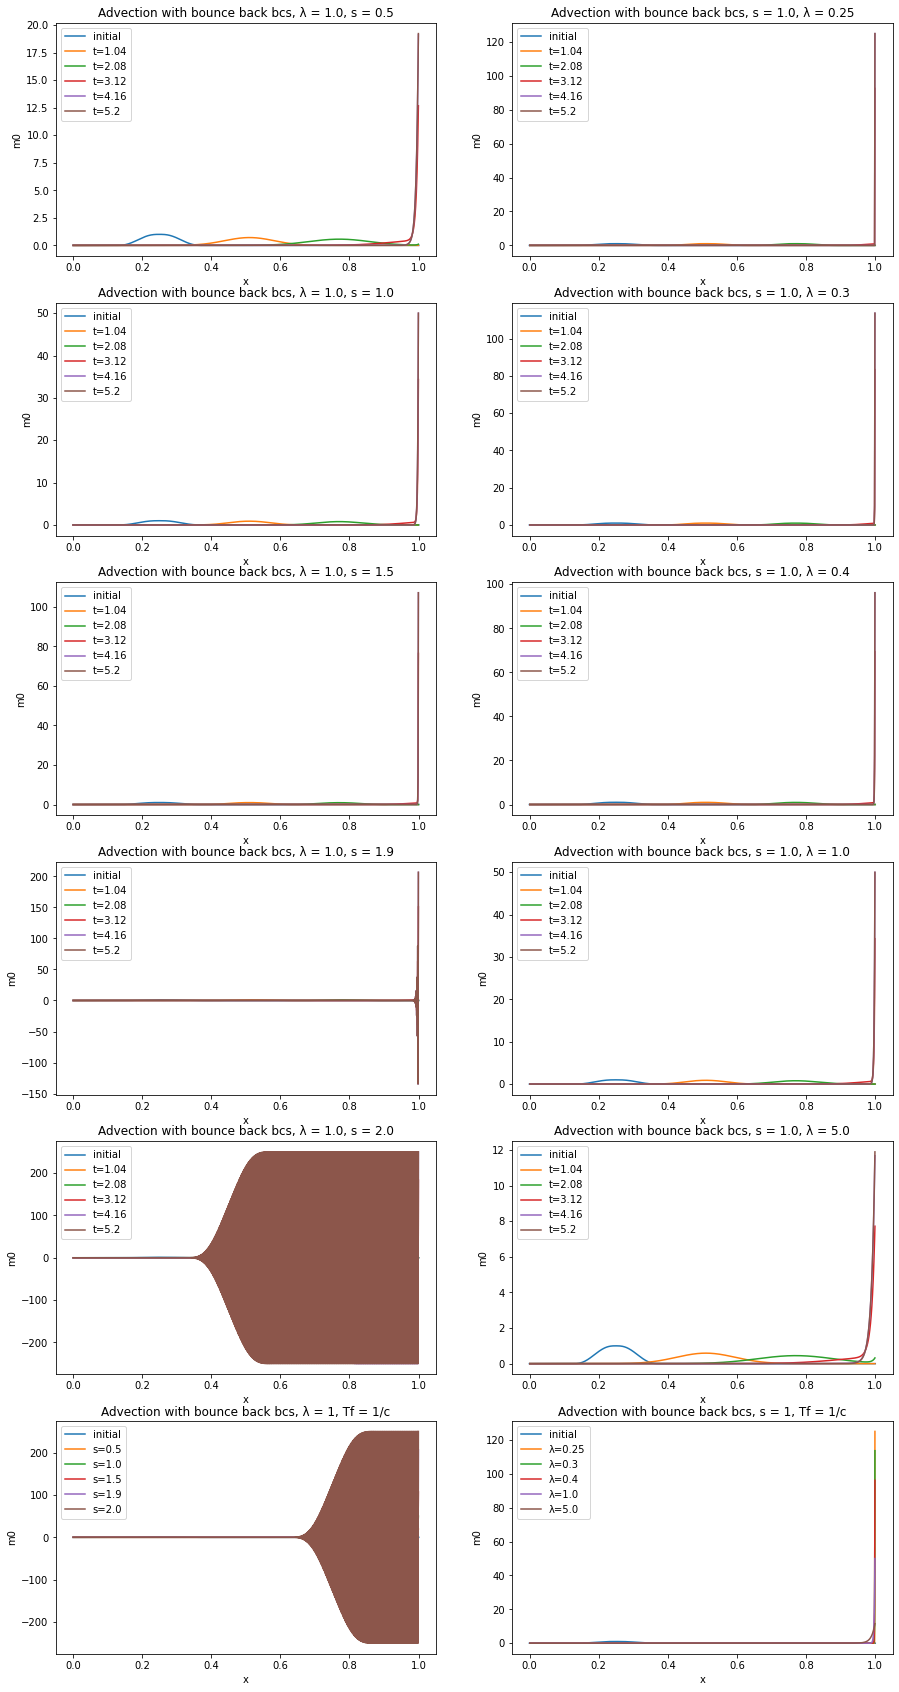

In [5]:
# Bounce Back conditions

nx = 1000
x = mesh(nx)
dx = 1./nx
c = 0.25
lamb = 1.
dt = dx/lamb
svec = [0.5,1.,1.5,1.9,2.]
nb_s = len(svec)

eq_advection = lambda m0: c*m0

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 5.2

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Advection with bounce back bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution après une période
Tf = 4.0
ax2 = axs[nb_s,0]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="bounce_back")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Advection with bounce back bcs, λ = 1, Tf = 1/c");


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.0
lambvec = [0.25, 0.3, 0.4, 1.,5.]

# On commence par afficher la solution pour différents temps
Tf = 5.2

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Advection with bounce back bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution après une période
Tf = 4.0
ax2 = axs[nb_s,1]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="bounce_back")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Advection with bounce back bcs, s = 1, Tf = 1/c");

Quelque soit la valeur de $s$ ou $\lambda$, on observe une explosion de l'amplitude de la solution lorsqu'elle atteint le bord droit : cette condition de bord est donc numériquement instable.

Pour proposer une explication, effectuons un développement formel au point $x = N_x$. On obtient :

$\begin{align} m_1(x=1) ≈ -λ f_0^r(x) + λ f_1(N_x) ≈ 0. \end{align}$.

Or, la valeur de $m_0$ n'est pas fixée à $0$ (Contrairement au bord ($x=0$) où les densités $f_0$ et $f_1$ sont nulles). On constate donc que l'état d'équilibre $m_1 = cm_0$, vers lequel le schéma tend normalement, ne peut pas être atteint sur le bord droit, ce qui rentre en conflit avec les points voisins, d'où le déclenchement d'instabilités.

Afin de chercher d'autres conditions qui soient cette fois-ci stables, il apparaît donc nécessaire de fixer la condition sur $m_0$ et pas $m_1$ (sauf dans le cas particulier où l'on imposerait la valeur d'équilibre).

#### Question 3 - Anti Bounce Back condition

Pour étudier la condition Anti Bounce Back, on réduit le nombre de points de la discrétisation spatiale à $N_x=200$ (au lieu de $N_x=1000$ jusqu'à présent), afin de mieux observer les phénomènes à l'oeuvre.

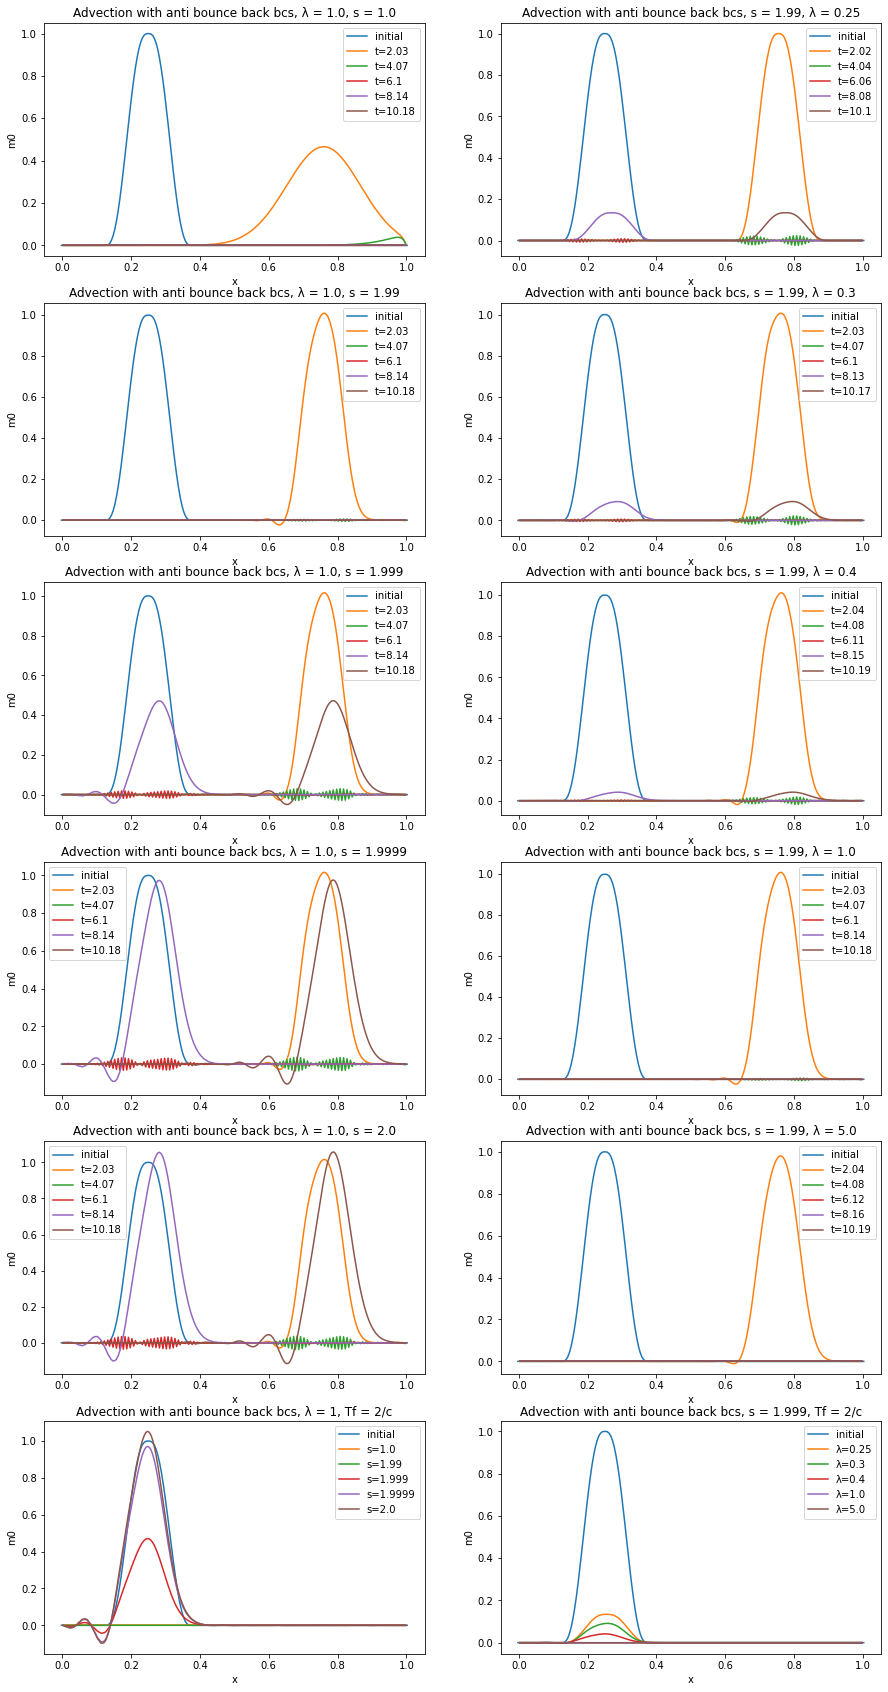

In [6]:
# Anti Bounce Back conditions

nx = 200
x = mesh(nx)
dx = 1./nx
c = 0.25
lamb = 1.
dt = dx/lamb
svec = [1.,1.99,1.999,1.9999,2.]
nb_s = len(svec)

eq_advection = lambda m0: c*m0

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])


#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 10.2

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="anti_bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Advection with anti bounce back bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution après deux périodes
Tf = 8.0
ax2 = axs[nb_s,0]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="anti_bounce_back")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Advection with anti bounce back bcs, λ = 1, Tf = 2/c");


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.99
lambvec = [0.25, 0.3, 0.4, 1., 5.]

# On commence par afficher la solution pour différents temps
Tf = 10.2

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="anti_bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Advection with anti bounce back bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution après deux périodes
Tf = 8.0
ax2 = axs[nb_s,1]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="anti_bounce_back")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Advection with anti bounce back bcs, s = 1.999, Tf = 2/c");

Cette fois-ci, la norme de la solution reste bornée à tout instant, la condition aux bords est donc numériquement stable.

Au début, la solution semble disparaître du côté gauche. Mais ensuite, pour des valeurs de $s$ suffisamment grandes et des valeurs de $λ$ suffisamment petites, on remarque que de l'information se propage en sens décroissant sous formes de trains d'ondes à faible amplitude. Lorsque cette information atteint le bord droit, alors la fonction de départ se reforme, et au bout de deux périodes ($T_f=2T$), elle vient se superposer à la condition initiale!

Ainsi, la condition de type anti bounce back n'est donc pas efficace comme condition de sortie, car dès que la diffusion numérique est faible un signal réapparait sur le bord droit, qui n'a aucun sens physique.

En tant que condition d'entrée en revanche, cette condition semble efficace, puisqu'on a vu qu'elle permet de simuler l'entrée d'un signal sur le bord gauche.

Enfin, dans le cas de paramètres induisant une forte diffusion numérique ($( s, λ ) = ( 1, 1 )$, par exemple) la condition anti bounce back peut être satisfaisante comme condition de sortie, car de toute façon le signal est suffisamment atténué pour rendre le phénomène ci-dessus négligeable. Tout se passe comme si au moment ou le signal atteint le bord droit, il n'y a plus d'information présente dans l'intervalle. En revanche, il n'y a plus le rôle de condition d'entrée non plus.

#### Question 4 : Copy condition

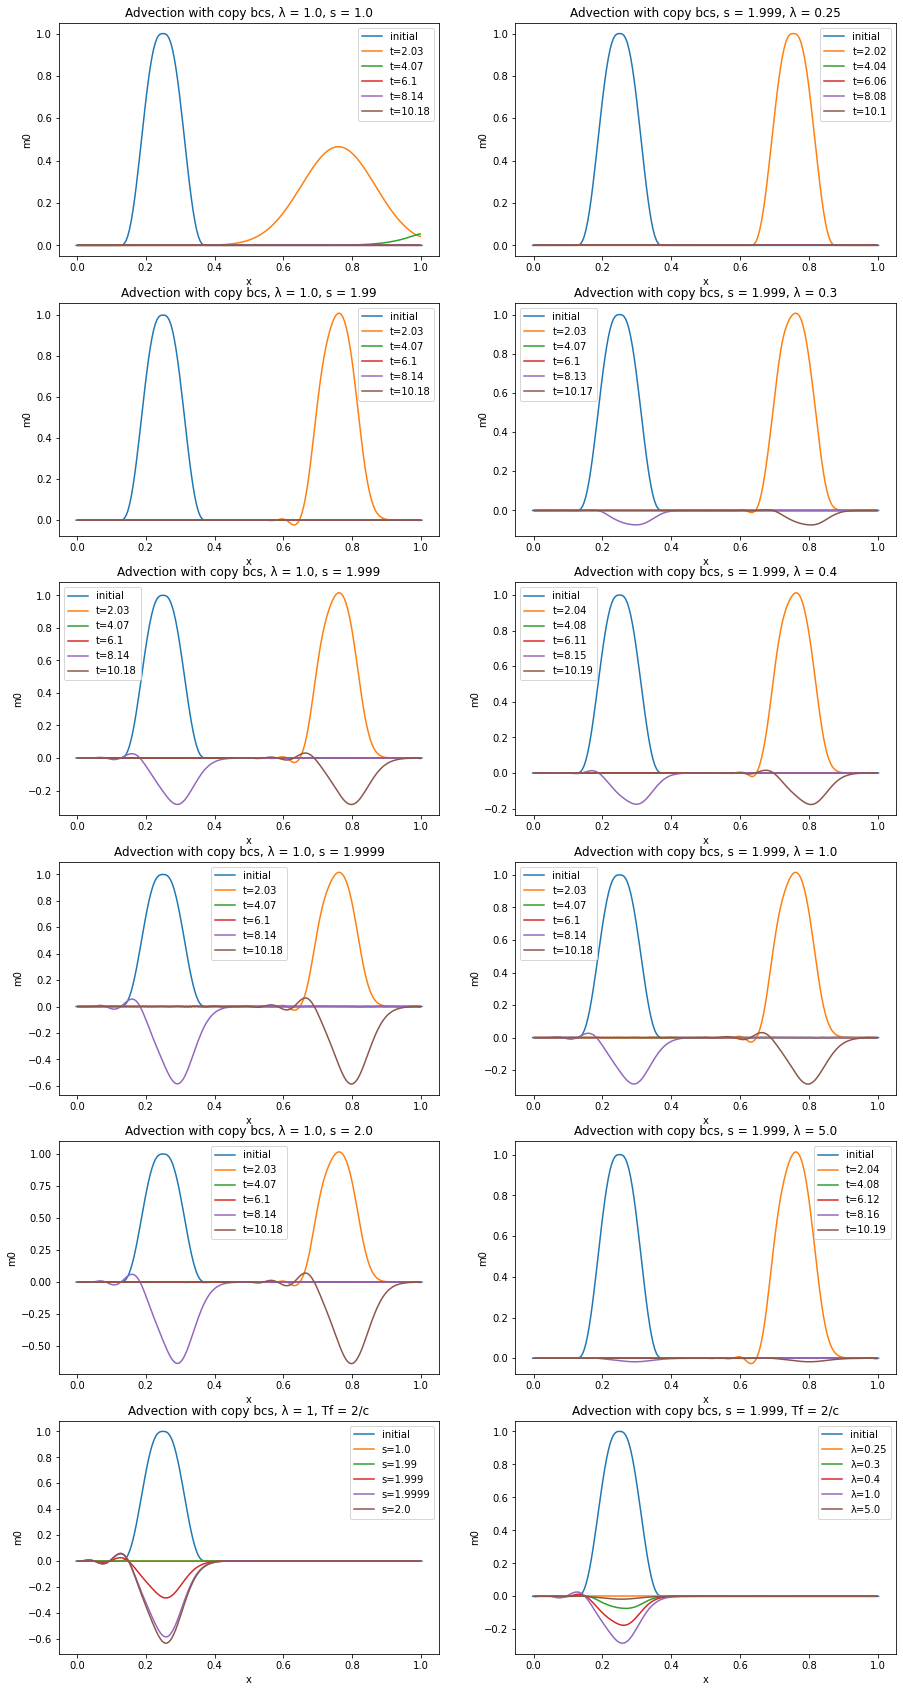

In [7]:
# Copy conditions

nx = 200
x = mesh(nx)
dx = 1./nx
c = 0.25
lamb = 1.
dt = dx/lamb
svec = [1.,1.99,1.999,1.9999,2.]
nb_s = len(svec)

eq_advection = lambda m0: c*m0

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 10.2

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="copy",nplots=5,axplot=ax1)
    ax1.set_title("Advection with copy bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution après deux périodes
Tf = 8.0
ax2 = axs[nb_s,0]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="copy")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Advection with copy bcs, λ = 1, Tf = 2/c");


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.999
lambvec = [0.25, 0.3, 0.4, 1., 5.]

# On commence par afficher la solution pour différents temps
Tf = 10.2

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="copy",nplots=5,axplot=ax1)
    ax1.set_title("Advection with copy bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution après deux périodes
Tf = 8.0
ax2 = axs[nb_s,1]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="copy")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Advection with copy bcs, s = 1.999, Tf = 2/c");

Comme dans le cas de la condition anti bounce back, si le signal semble disparaître en atteignant le bord droit, de l'information se propage en fait en sens inverse. Cette fois-ci, même pour un faible pas d'espace, elle n'est quasiment pas observable. Un autre signal apparaît ensuite sur le bord droit, c'est le signal initial renversé et d'amplitude diminuée (même sans diffusion numérique).

Ainsi, les conclusion pour la condition copy sont presque les mêmes que pour la condition anti bounce back. S'il n'y a pas suffisamment de diffusion, ce n'est pas une condition de sortie efficace car un signal non physique apparaît. En ce qui concerne la condition d'entrée, étant donné que le signal arrivant sur le bord gauche et renversée et d'amplitude diminué, la condition copy ne semble pas satisfaisante. Sur ce point, il y a donc une différence avec la condition anti bounce back.

Dans le cas d'une forte diffusion, la condition copy peut éventuellement être acceptée comme condition de sortie, et ne joue pas le rôle d'une condition d'entrée.

#### Question 5 : Condition sortante (Helluy condition)

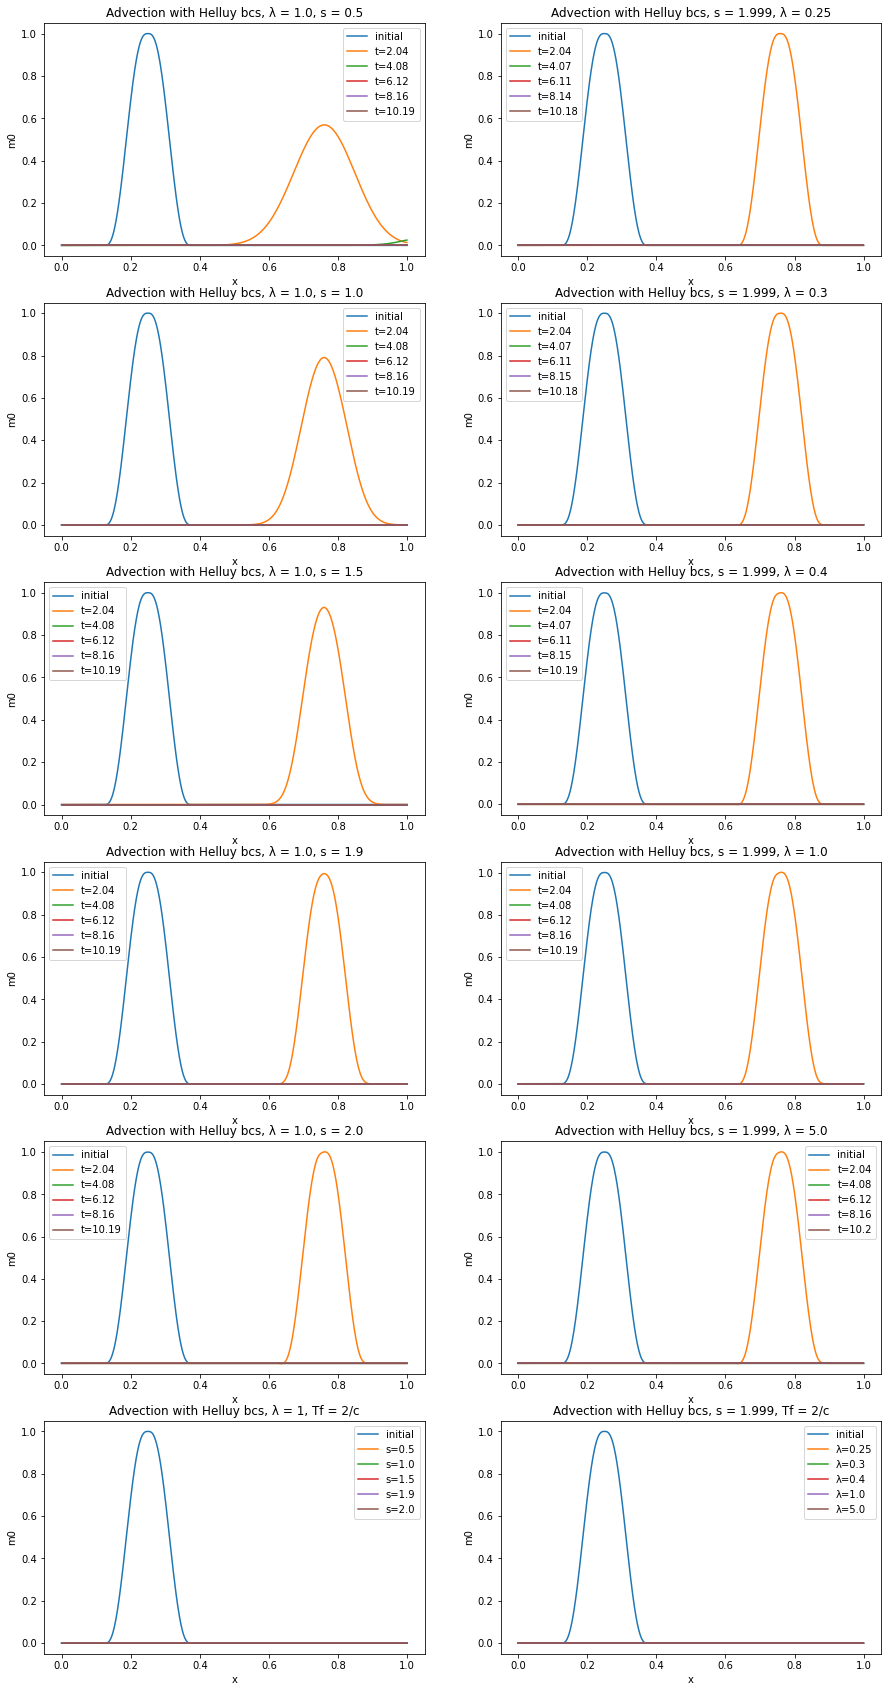

In [8]:
# Helluy conditions

nx = 1000
x = mesh(nx)
dx = 1./nx
c = 0.25
lamb = 1.
dt = dx/lamb
#svec = [1.,1.99,1.999,1.9999,2.]
svec = [0.5,1.,1.5,1.9,2.]
nb_s = len(svec)

eq_advection = lambda m0: c*m0

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 10.2

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="helluy",nplots=5,axplot=ax1)
    ax1.set_title("Advection with Helluy bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution après deux périodes
Tf = 8.0
ax2 = axs[nb_s,0]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="helluy")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Advection with Helluy bcs, λ = 1, Tf = 2/c");


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.999
lambvec = [0.25, 0.3, 0.4, 1., 5.]

# On commence par afficher la solution pour différents temps
Tf = 10.2

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="helluy",nplots=5,axplot=ax1)
    ax1.set_title("Advection with Helluy bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution après deux périodes
Tf = 8.0
ax2 = axs[nb_s,1]
ax2.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,m0_init_bump,eq_advection,2,bcs="helluy")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Advection with Helluy bcs, s = 1.999, Tf = 2/c");

Cette fois-ci, quel que soit le niveau de diffusion numérique, l'information atteignant le bord droit disparaît pour de bon, sans propagation inverse ni réapparition à gauche. Ainsi, la condition sortante est, comme son nom l'indique, une bonne condition de sortie.

### Exercice 2 : Equation de Burgers

On reprend les tests précédant pour la résolution de l'equation de Burgers.

In [9]:
def solution_adimensionnee (x, t):
    """
    A normalized hat solution of the Burgers equation

                          /\                       y=1
                         /  \
                        /    \
    __________________ /      \ __________________ y=0
                    x= -1  0   1
    """
    y = np. zeros (x. shape )
    if t < 0:
        return y
    if t < 1:
        xi = t
        indr = np.where(np. logical_and (x >= t, x < 1))
        y[ indr ] = 1 - 1/(1 -t)*( x[ indr ] -t)
    else :
        xi = 2* np. sqrt (.5*(1+ t)) - 1
    indl = np.where(np.logical_and (x >= -1 , x <= xi))
    y[ indl ] = 1/(1+ t )*(1+ x[ indl ])
    return y

def solution (x, t, xmin , xmax , ymax =1):
    """
    Hat solution of the Burgers equation
    adapted to the bounds of the figure
    """
    if ymax < 0:
        print ("Error, ymax < 0 in solution ")
        return
    middle , width = .75* xmin +.25* xmax , 0.125*( xmax - xmin )
    xx = 1/ width *(x - middle )
    return ymax * solution_adimensionnee (xx , ymax / width *t)

In [10]:
def equilibrium_burgers(m0):
    out = np.zeros(m0.shape)
    for i in range(len(m0)):
        out[i] = m0[i]**2/2
    return out

def init_burgers(x,xmin,xmax,ymax):
    return solution(x,0,xmin,xmax,ymax)

#### Question 1 : Conditions périodiques

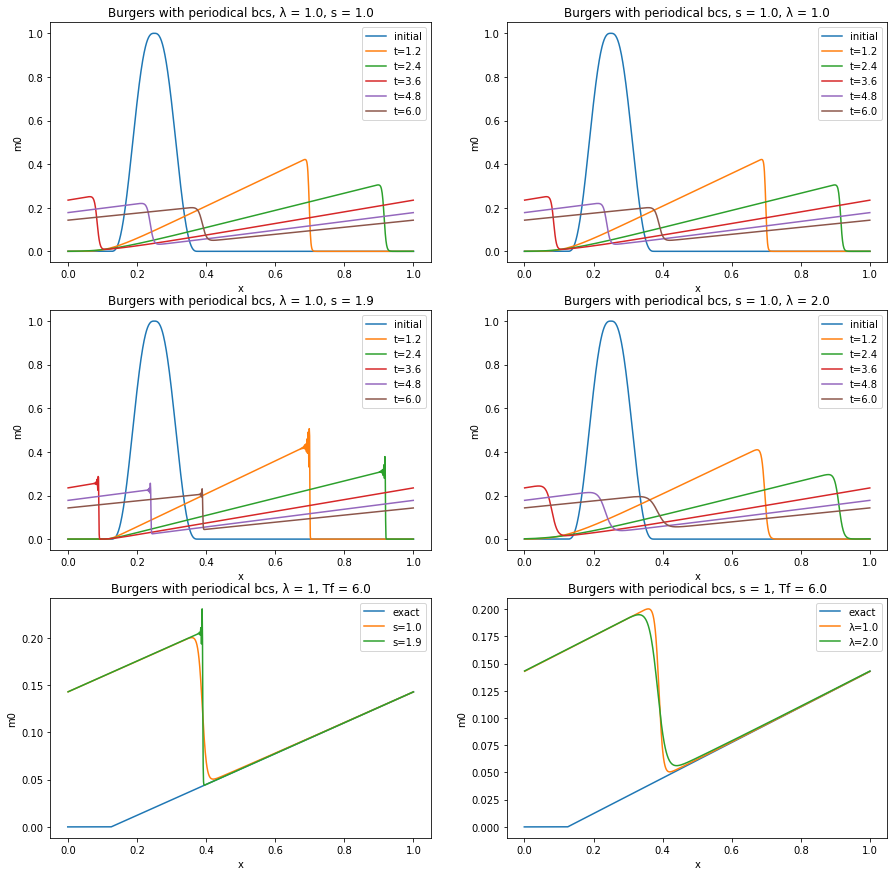

In [11]:
# Conditions périodiques 

nx = 1000

x = mesh(nx)
dx = 1./nx
lamb = 1.
dt = dx/lamb
svec = [1.,1.9]
nb_s = len(svec)

ymax = 1.

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 6.

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="periodic",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with periodical bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution en temps long
Tf = 6.
ax2 = axs[nb_s,0]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="periodic")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Burgers with periodical bcs, λ = 1, Tf = " + str(Tf));


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.
lambvec = np.array([1.,2.])

# On commence par afficher la solution pour différents temps
Tf = 6.

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="periodic",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with periodical bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution en temps long
Tf = 6.
ax2 = axs[nb_s,1]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="periodic")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Burgers with periodical bcs, s = 1, Tf = " + str(Tf));

Pour l'équation de Burgers, la condition aux bords périodique se comporte comme on peut s'y attendre : lorsque la solution atteint le bord droit, elle réapparait sur le bord droit. Cependant, puisque cette fois-ci la solution de l'équation ne subit plus seulement un déplacement comme pour l'advection, mais aussi une déformation au cours du temps, on n'a plus une solution périodique. En fait, à partir du moment où l'information réapparaît sur le bord gauche, on peut douter que ce type de comportement corresponde à un quelconque phénomène physique : on peut d'ailleurs voir sur les deux figures du bas que le résultat obtenu est différent de la solution exacte côté gauche. Côté droit en revanche, tout se passe bien et on reste fidèle à la solution exacte.

Mettre des conditions au bord périodique ne semble donc pas très adapté lorsque l'on résout l'équation de Burgers, du moins après le moment où la solution a atteint le bord droit.

#### Question 2 : Condition Bounce Back

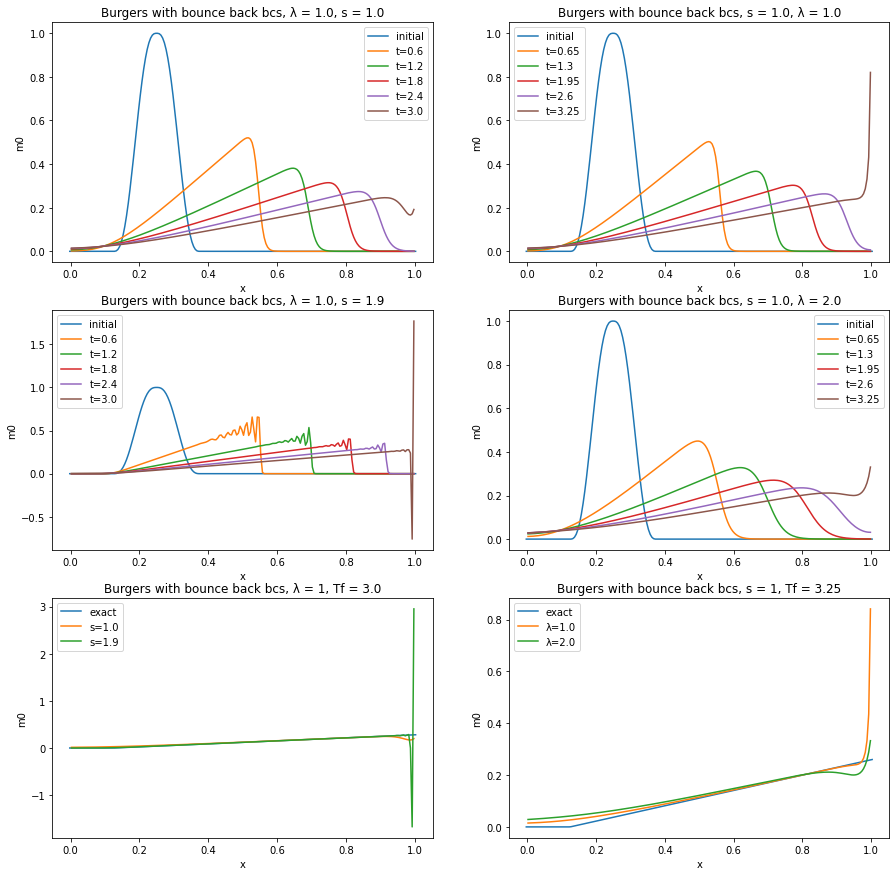

In [12]:
# Conditions Bounce Back 

nx = 200

x = mesh(nx)
dx = 1./nx
lamb = 1.
dt = dx/lamb
svec = [1.,1.9]
nb_s = len(svec)

ymax = 1.

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 3.

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with bounce back bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution en temps long

ax2 = axs[nb_s,0]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="bounce_back")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Burgers with bounce back bcs, λ = 1, Tf = " + str(Tf));


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.
lambvec = np.array([1.,2.])

# On commence par afficher la solution pour différents temps
Tf = 3.25

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with bounce back bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution en temps long

ax2 = axs[nb_s,1]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="bounce_back")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Burgers with bounce back bcs, s = 1, Tf = " + str(Tf));

De même que pour l'équation d'advection, la condition Bounce Back pour l'équation de Burgers est instable. L'explication proposée dans l'exercice 1 peut être proposée dans ce cas aussi. On observe que l'instabilité apparait extrêmement rapidement lorsque la solution atteint le bord droit - plus vite que dans le cas de l'advection. Ceci peut être expliqué par le fait que la solution étant discontinue, elle propage plus rapidement une instabilité.

De plus, l'instabilité apparaît plus rapidement lorsque $s$ est plus proche de $2$ ou lorsque $\lambda$ est plus proche de $y_{\max}$, l'amplitude initiale de $m_0$ (donc lorsque l'on a moins de diffusion).

#### Question 3 : Condition anti Bounce Back

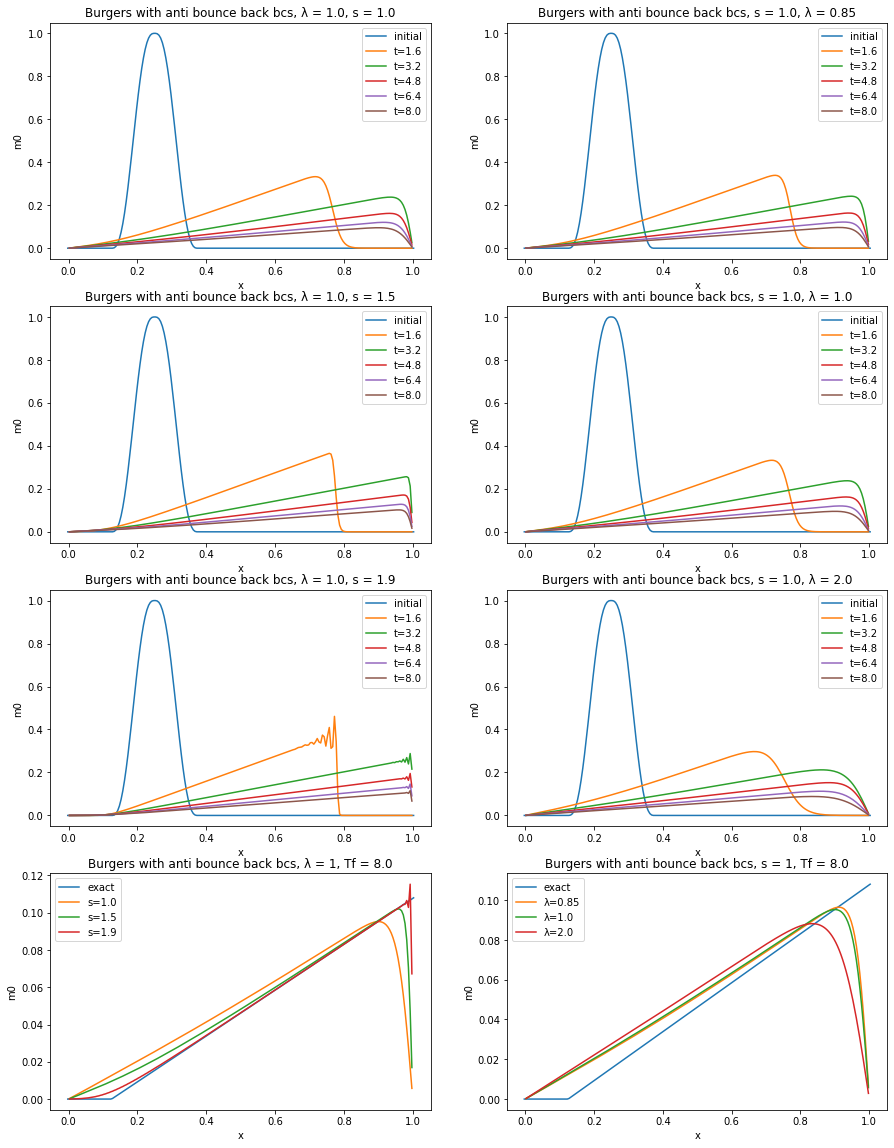

In [37]:
# Conditions anti Bounce Back 

nx = 200

x = mesh(nx)
dx = 1./nx
lamb = 1.
dt = dx/lamb
svec = [1.,1.5,1.9]
nb_s = len(svec)

ymax = 1.

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 8.

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="anti_bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with anti bounce back bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution en temps long

ax2 = axs[nb_s,0]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="anti_bounce_back")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Burgers with anti bounce back bcs, λ = 1, Tf = " + str(Tf));


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.
lambvec = np.array([0.85,1.,2.])

# On commence par afficher la solution pour différents temps
Tf = 8.

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="anti_bounce_back",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with anti bounce back bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution en temps long

ax2 = axs[nb_s,1]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="anti_bounce_back")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Burgers with anti bounce back bcs, s = 1, Tf = " + str(Tf));

Pour la condition anti bounce back, on remarque qu'en atteignant le bord droit, la solution semble cesser de se déplacer mais diminue simplement d'amplitude. En fait, si l'on compare avec la solution exacte, on remarque que pour une faible diffusion, la solution obtenue est très proche. Seuls les derniers points à droite différent, mais c'est normal puisqu'ils sont fixés à $0$.

Par ailleurs, le phénomène de "retour de l'information" qui avait pu être observé pour l'équation d'advection n'apparaît pas ici. On peut avancer pour cela l'hypothèse suivante. Pour l'équation de Burgers, on ne peut pas annuler le terme de diffusion comme pour l'advection : fixer $s=2$ conduit à des instabilités, et la valeur de $\phi'(m_0)$ n'est pas constante donc on ne peut pas choisir un $\lambda$ annulant la diffusion. Or, on a vu dans le cas de l'advection que lorsqu'il y avait suffisamment de diffusion, l'information propagée en sens inverse par la condition anti bounce back, et la réplique de la solution en résultant, étaient bien moins visibles qu'en l'absence de diffusion. On peut donc supposer que c'est ce qui se passe ici.

La condition anti bounce back semble donc a priori être une bonne condition de sortie pour l'équation de Burgers, puisque la solution obtenue reste proche de la solution exacte, et aucune information n'apparait sur le bord gauche en temps long. Mais la condition de Dirichlet sur le bord droit pose quand même problème, puisque la solution exacte ne vaut pas 0 sur ce bord, et l'écart créé entre solution exacte et approché augmente avec la diffusion.

Il est donc nécessaire dans la suite de trouver une meilleure condition de sortie.

#### Question 4 : Condition copy

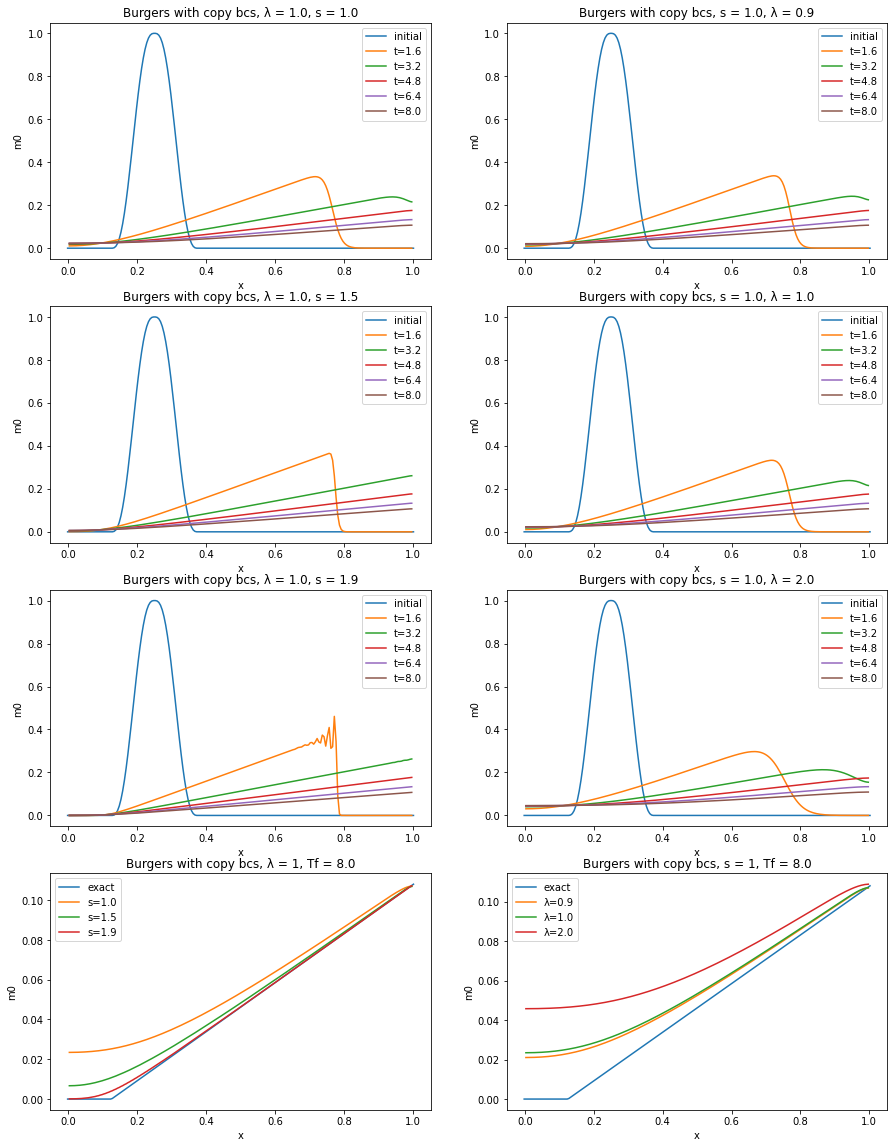

In [50]:
# Conditions copy 

nx = 200

x = mesh(nx)
dx = 1./nx
lamb = 1.
dt = dx/lamb
svec = [1.,1.5,1.9]
nb_s = len(svec)

ymax = 1.

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 8.

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="copy",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with copy bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution en temps long

ax2 = axs[nb_s,0]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="copy")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Burgers with copy bcs, λ = 1, Tf = " + str(Tf));


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.
lambvec = np.array([0.9,1.,2.])

# On commence par afficher la solution pour différents temps
Tf = 8.

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="copy",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with copy bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution en temps long

ax2 = axs[nb_s,1]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="copy")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Burgers with copy bcs, s = 1, Tf = " + str(Tf));

Au lieu d'une condition de Dirichlet, c'est maintenant une condition de Neumann qui est imposée à $m_0$ sur les bords droit et gauche. La solution approchée s'éloigne légèrement de la solution afin de satisfaire à cette condition, mais ce n'est plus un problème car en fait la solution exacte satisfait déjà presque à la condition de Neumann.

En temps long, on vérifie bien qu'aucune information ne s'est propagée en sens inverse.

La condition copy est donc une bonne condition de sortie pour l'équation de Burgers.

On peut remarquer que les valeurs à gauche des solutions approchées en présence de diffusion s'éloignent légèrement de la solution exacte. Ce phénomène de diffusion n'est pas du spécifiquement à la condition de Neumann, mais au vu des résultats de la condition anti bounce back, une solution pour le corriger pourrait être d'imposer une condition de Dirichlet sur le bord gauche (en gardant du Neumann sur le bord droit).

#### Question 5 : Condition sortante

Pour la condition sortante, on s'inspire de celle qui a été proposée pour l'advection. On commence par fixer le bord gauche par une condition de Dirichlet sur $m_0$. Pour le bord droit, on cherche à imposer l'équilibre, c'est-à-dire:

$\begin{align} m_1(x=1) ≈ m_1^{eq}(x=1). \end{align}$.

On a $m_1(x=1) ≈ λ(f_1^{N_x} - f_0^r)$ et $m_1^{eq}(x=1) = \frac{(m_0(x=1))^2}{2} ≈ \frac{(f_1^{N_x} + f_0^r)^2}{2}$.

On obtient l'équation du 2nd degré d'inconnue $X = f_0^r$: $X^2 + 2(f_1^{N_x} + λ ) X +((f_1^{N_x})^2 - 2λ f_1^{N_x}) = 0.$

Le discriminant est $Δ = 4 λ (λ + 4 f_1^{N_x}).$ Il est toujours positif, car $λ$ est positif et $f_1$ l'est aussi en tant que densité.

Les racines sont donc $X_{+,-} = - f_1^{N_x} - λ ± \sqrt{λ (λ + 4 f_1^{N_x})}.$ On voit que $X_-$ sera toujours négative, donc on conserve $X_+$. Finalement, la condition sortante s'écrit:

$\begin{align} f_0^r = - f_1^{N_x} - λ ± \sqrt{λ (λ + 4 f_1^{N_x})},  f_1^l = -f_0^0. \end{align}$.

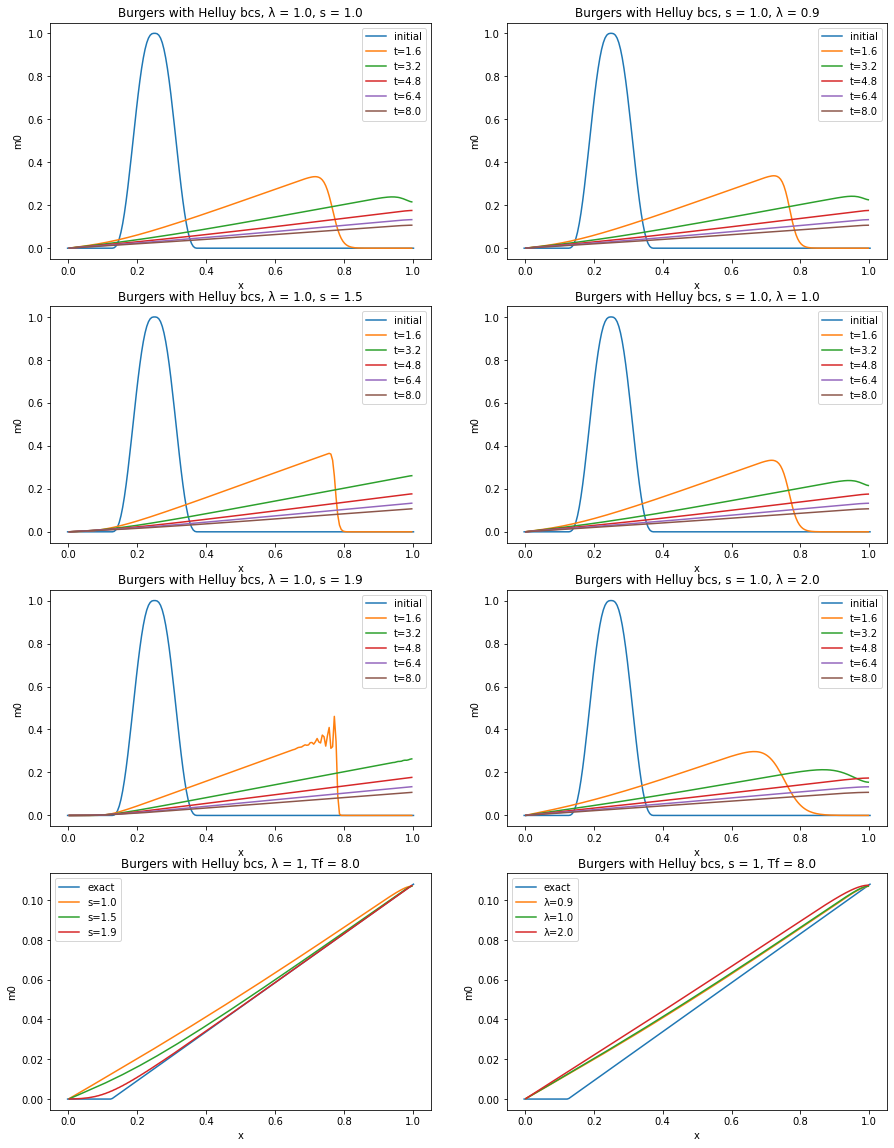

In [51]:
# Condition sortante 

nx = 200

x = mesh(nx)
dx = 1./nx
#lamb = 1.
lamb = 1.
dt = dx/lamb
svec = [1.,1.5,1.9]
nb_s = len(svec)

ymax = 1.

fig, (axs) = plt.subplots(nb_s+1,2,figsize=[15,5*(nb_s+1)])

#                 On fixe d'abord λ = 1 et on fait varier s.             

# On commence par afficher la solution pour différents temps
Tf = 8.

for i,s in enumerate(svec):
    ax1=axs[i,0]
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="helluy_burgers",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with Helluy bcs, λ = "+str(lamb)+", s = "+str(s));

# On observe la solution en temps long

ax2 = axs[nb_s,0]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,s in enumerate(svec):
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="helluy_burgers")
    plot_lbm(x,m0,"s",s,ax=ax2)
ax2.set_title("Burgers with Helluy bcs, λ = 1, Tf = " + str(Tf));


#            Puis on fixe s = 1 et on fait varier λ.             

s = 1.
lambvec = np.array([0.9,1.,2.])
#lambvec = np.array([4.,6.])

# On commence par afficher la solution pour différents temps
Tf = 8.

for i,lamb in enumerate(lambvec):
    ax1=axs[i,1]
    dt = dx/lamb
    ax1.plot(x,m0_init_bump(x,0.,1.,2),label="initial")
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="helluy_burgers",nplots=5,axplot=ax1)
    ax1.set_title("Burgers with Helluy bcs, s = "+str(s)+", λ = "+ str(lamb));

# On observe la solution en temps long

ax2 = axs[nb_s,1]
ax2.plot(x,solution(x,Tf,0.,1.,ymax),label="exact")
for i,lamb in enumerate(lambvec):
    dt = dx/lamb
    m0 = run_lbm(x,dt,Tf,lamb,s,init_burgers,equilibrium_burgers,ymax,bcs="helluy_burgers")
    plot_lbm(x,m0,"λ",lamb,ax=ax2)
ax2.set_title("Burgers with Helluy bcs, s = 1, Tf = " + str(Tf));

On obtient là encore une bonne condition de sortie en temps long (pas de retour d'information).

La condition de type "Helluy" pour l'équation de Burgers apporte donc dans ce cas une solution satisfaisante, toutefois elle ne fait pas mieux qu'une condition copy. Pour cette raison, il semble préférable de l'éviter. En effet, la résolution de l'équation à l'équilibre présente un risque de chercher à calculer des racines de nombre négatif (selon les valeurs prises par $f_1$ au cours du calcul), par exemple.

Si l'on cherche à appliquer la condition d'équilibre sur le bord gauche, on obtient en effet un discriminant négatif pour certaines valeurs de $f_0$.

La condition de Neumann sur le bord droit, et de Dirichlet sur le bord gauche, semble donc préférable à la condition de type Helluy pour l'équation de Burgers.